In [1]:
import pandas as pd
from sklearn.decomposition import PCA, SparsePCA
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [9]:
df = pd.read_csv('cluster_sample.csv', header=0)

In [10]:
# Normalize features before PCA
for c in df.columns:
    if df[c].dtype == object: continue
    if 'survey' in c: continue
    if c == 'pid': continue
    
    df[c] -= df[c].mean()
    df[c] /= df[c].std()

In [15]:
# Transform the data for PCA
pca = PCA(n_components=5, svd_solver='full')
df_out = df.copy(deep=True)
df_pca = df.drop(['pid','date','day_of_week'], axis=1).fillna(0)
df_trans = pca.fit_transform(df_pca)
pca_cols = [f'Principal Component {i}' for i in range(df_trans.shape[1])]
for i, c in enumerate(pca_cols):
    df_out[c] = df_trans[:, i]

<Figure size 432x288 with 0 Axes>

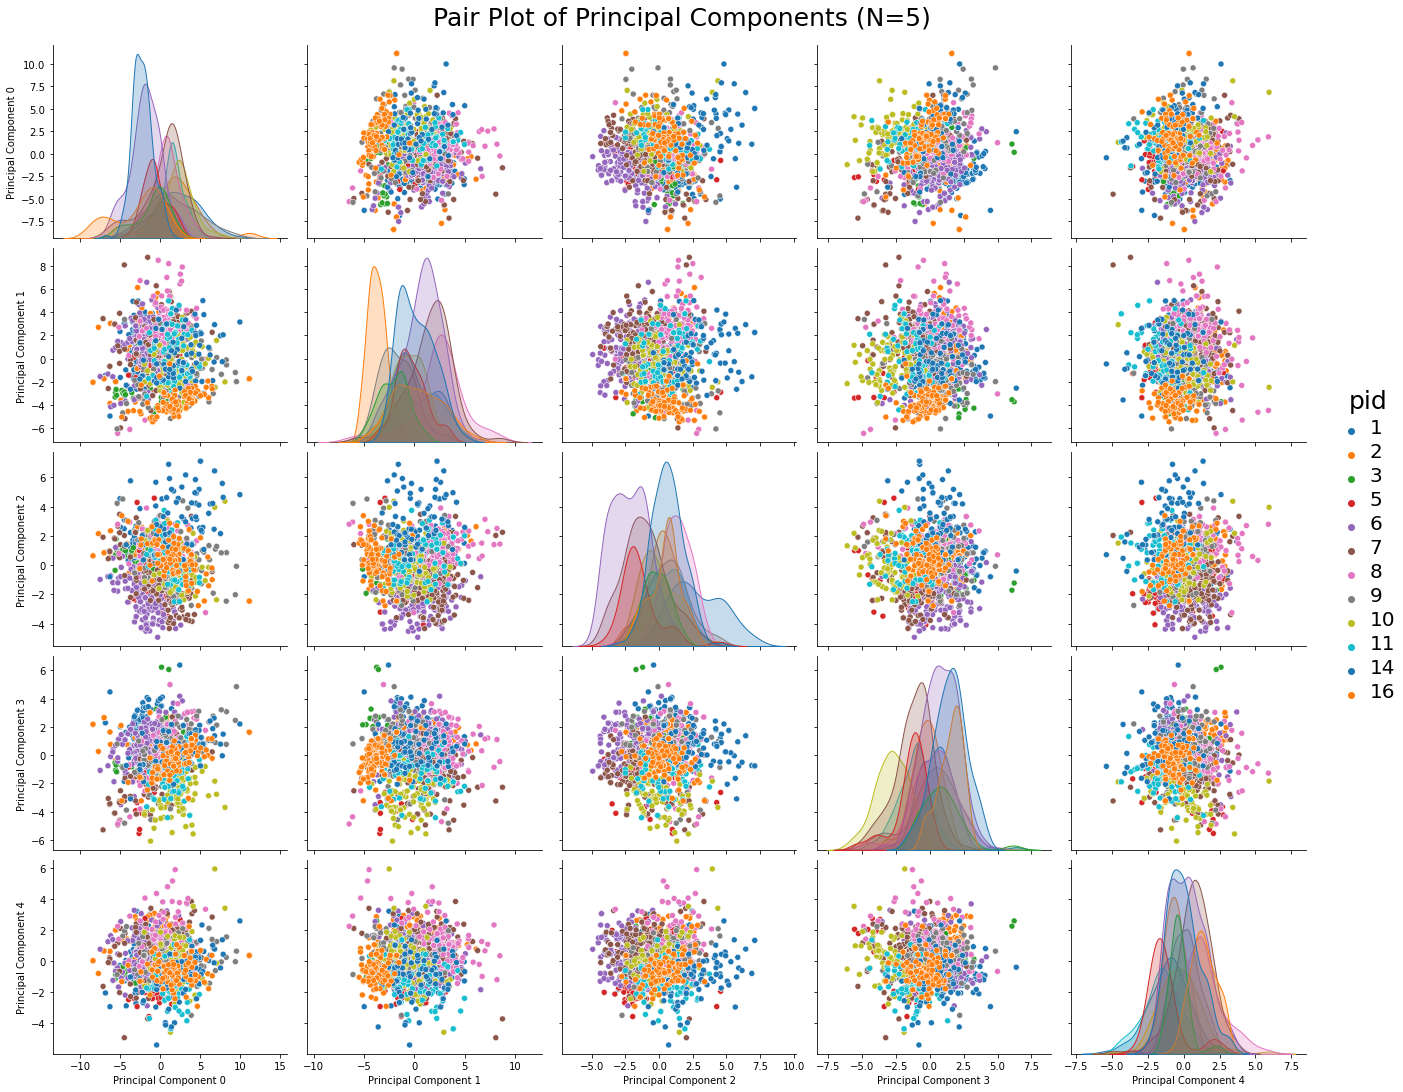

In [31]:
# Plot the principal components
plt.figure()
ax = sns.pairplot(data=df_out[pca_cols+['pid']], hue='pid', palette=sns.color_palette("tab10", n_colors=len(df_out['pid'].unique())))
ax.fig.set_size_inches(20,15)
ax.fig.suptitle("Pair Plot of Principal Components (N=5)", y=1.02, fontsize=25)
plt.setp(ax._legend.get_title(), fontsize=25)
plt.setp(ax._legend.get_texts(), fontsize=20)
plt.savefig('pc_pairplot.png', bbox_inches='tight')

In [37]:
# Given 1:1 membership list w/ pid list, as well as number of clusters, find the majority membership
def get_buddies(membership, pids, n_clusters):
    buddies = {pid: {i:0 for i in range(n_clusters)} for pid in list(pids.unique())}
    for m, pid in zip(membership, pids):
        buddies[pid][m] += 1
    groups = [[] for _ in range(n_clusters)]
    for key, value in buddies.items():
        groups[max(value, key=value.get)].append(key)
    return groups

In [40]:
# Clustering for poster
n_clusters=3
km = KMeans(n_clusters=n_clusters).fit(df_out[pca_cols])
membership = km.predict(df_out[pca_cols])
df_out['cluster'] = membership

In [64]:
# Find majority groups
groups = get_buddies(membership, df_out['pid'], n_clusters)

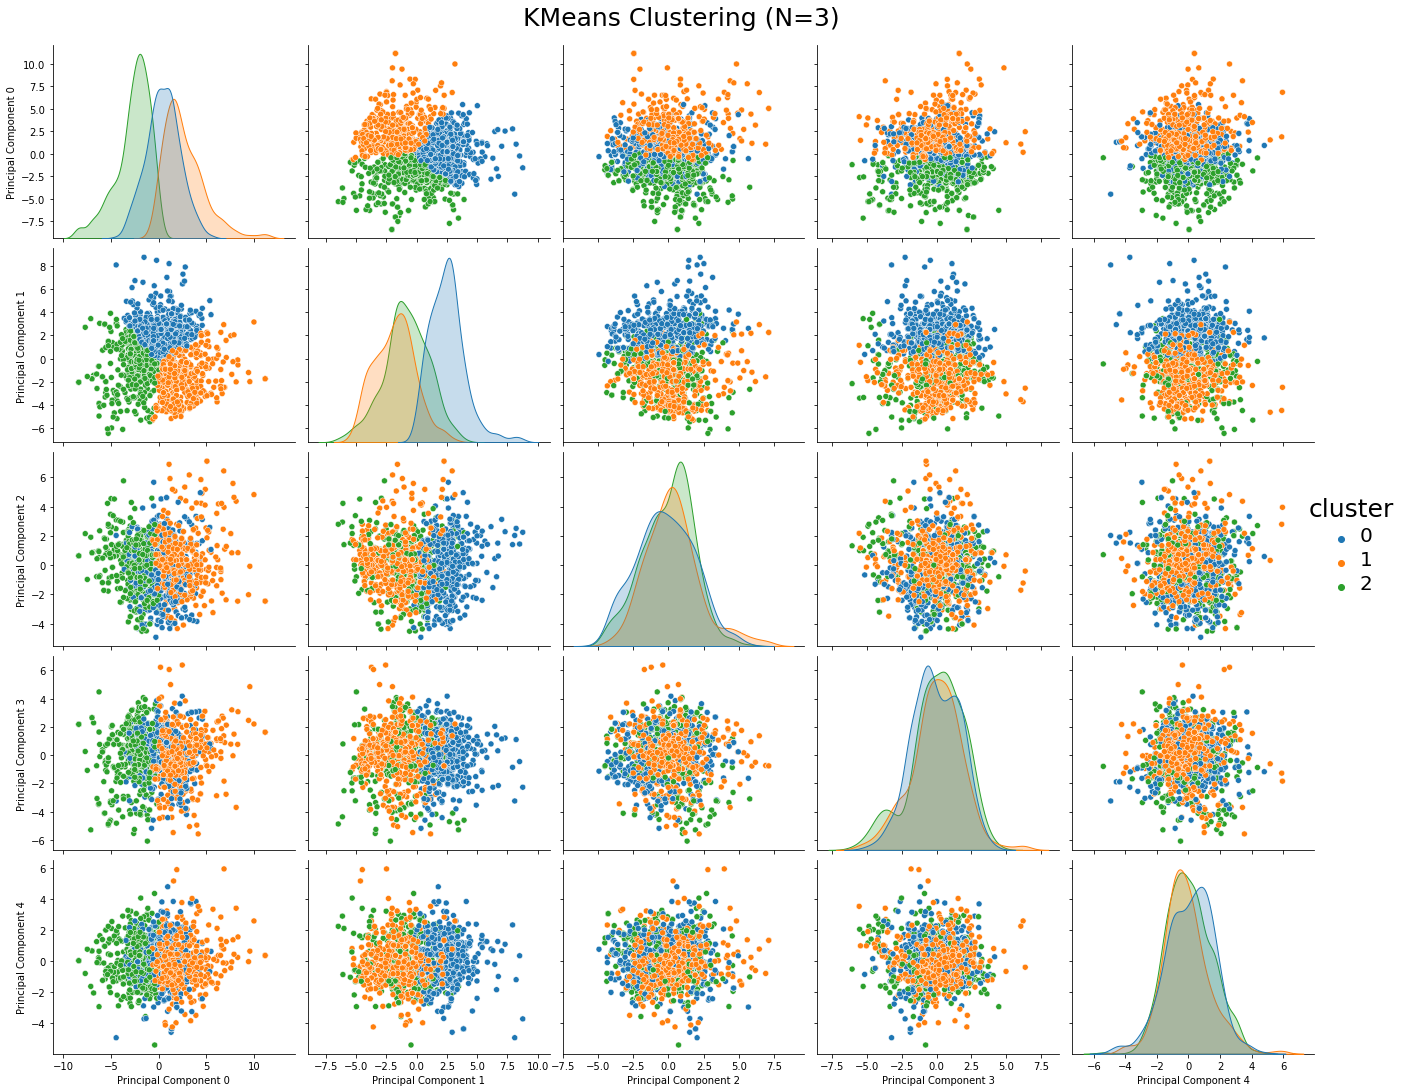

In [43]:
# Plot groups
ax = sns.pairplot(data=df_out[pca_cols+['cluster']], hue='cluster', palette=sns.color_palette("tab10", n_colors=n_clusters))
ax.fig.set_size_inches(20,15)
ax.fig.suptitle("KMeans Clustering (N=3)", y=1.02, fontsize=25)
plt.setp(ax._legend.get_title(), fontsize=25)
plt.setp(ax._legend.get_texts(), fontsize=20)
plt.savefig('cluster_step1.png', bbox_inches='tight')

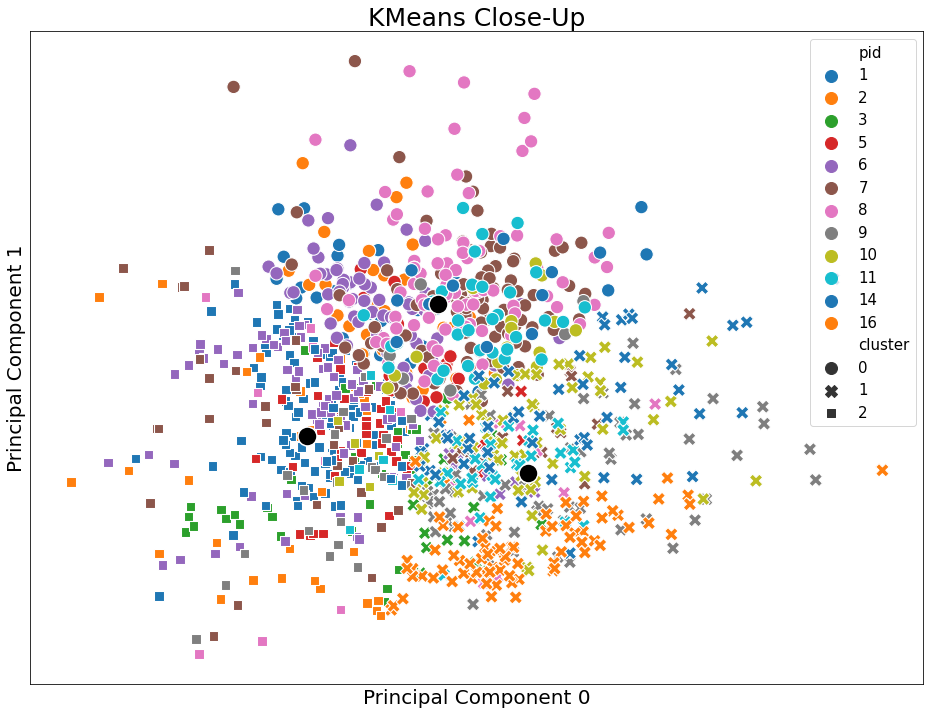

In [60]:
# Plot closeup of PC0 and PC1
plt.figure(figsize=(16,12))
ax = sns.scatterplot(s=180,data=df_out[['Principal Component 0','Principal Component 1','cluster', 'pid']], x='Principal Component 0', y='Principal Component 1', hue='pid', style='cluster', palette=sns.color_palette("tab10", n_colors=len(df_out['pid'].unique())))
ax = sns.scatterplot(s=360, x=km.cluster_centers_[:, 0], y=km.cluster_centers_[:, 1], ax=ax, color='black')
plt.xticks(())
plt.yticks(())
plt.xlabel('Principal Component 0', fontsize=20)
plt.ylabel('Principal Component 1', fontsize=20)
plt.title("KMeans Close-Up", fontsize=25)
plt.legend(fontsize=15, title_fontsize=20, markerscale=2)
plt.savefig('cluster_closeup.png', bbox_inches='tight')
#plt.show()

In [65]:
# Find large groups
large_groups = [g for g in groups if len(g) >= 4]

In [81]:
# Hierarchical clustering on one group
subset = large_groups[1]
df_subset = df_out[df_out['pid'].isin(subset)].reset_index()

In [82]:
# Rerun kmeans on it
n_clusters=3
km = KMeans(n_clusters=n_clusters).fit(df_subset[pca_cols])
membership = km.predict(df_subset[pca_cols])
df_subset['cluster'] = membership

In [83]:
# Our subclusters!
get_buddies(membership, df_subset['pid'], n_clusters)

[[1, 2], [3, 5, 6], []]